# Database creation

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders #(pip install split-folders)
import tensorflow as tf
import shutil
import urllib.request
import zipfile

2022-03-25 17:59:25.420534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 17:59:25.420552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Downloading the database

In [2]:
# If you do not posess the AnimalFace.zip archive, this cells downloads it

if not os.path.exists('data'):
    os.makedirs('data/')
    
if not os.path.exists('data/images/') or len(os.listdir('data/images/')) == 0:
    if not os.path.exists('data/AnimalFace.zip'):
        url = 'https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip'
        urllib.request.urlretrieve(url, 'data/AnimalFace.zip')
    with zipfile.ZipFile('data/AnimalFace.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')
    os.rename('data/Image/', 'data/images/')

if os.path.exists('./data/images/Natural'):
    shutil.rmtree('./data/images/Natural')

# Download the zip and unzip in a folder named Images
# And we delete the Natural folder which contains only 8 images non related to AnimalFaces

## Chosing the categories for One Shot Learning

In [3]:
categories = os.listdir('data/images')
if os.path.exists('data/OneShotImages/'):
    oneshot_cats = sorted(os.listdir('data/OneShotImages/'))
    categories += oneshot_cats
categories = sorted([cat for cat in categories])
print(f'There are {len(categories)} different categories, which are:', categories, '\n', sep='\n')

if not os.path.exists('data/OneShotImages/'):
    np.random.seed(42)
    oneshot_cats = np.random.choice(len(categories), 5)
    oneshot_cats = [categories[num] for num in oneshot_cats]
print('The chosen categories for One-Shot Learning are:', oneshot_cats)

There are 20 different categories, which are:
['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'PandaHead', 'PigHead', 'PigeonHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


The chosen categories for One-Shot Learning are: ['DuckHead', 'WolfHead', 'PigHead', 'LionHead', 'EagleHead']


In [4]:
train_cats = list(set(categories) - set(oneshot_cats))

In [5]:
if not os.path.exists('data/OneShotImages/'):
    os.makedirs('data/OneShotImages/')
    for cat in oneshot_cats:
        shutil.move('data/images/' + cat, 'data/OneShotImages/' + cat)

## Separating the folders into train and test

In [6]:
IMAGES_PATH = 'data/images/'
IMAGES_OS_PATH = 'data/OneShotImages/'

In [7]:
splitfolders.fixed(IMAGES_OS_PATH, output='data/', seed=42, fixed=(1, 0, -1), group_prefix=None, move=False)
shutil.rmtree('data/val/')
os.rename('data/train/', 'data/train_os/')
os.rename('data/test/', 'data/test_os/')



Copying files: 502 files [00:00, 12057.71 files/s]


In [8]:
splitfolders.ratio(IMAGES_PATH, output='data/', seed=42, ratio=(.8, .0, .2), group_prefix=None, move=False)
shutil.rmtree('data/val/')

Copying files: 1905 files [00:00, 16187.89 files/s]


In [9]:
# After having separated the database into train and tests sets
# We create empty folders with the absent categories 
# This will enable the dataset loading functions from pytorch or tensorflow to 
# still understand that there is 20 categories even though there are no photos
# of the One Shot categories in the train set and no photos from the train folder
# in the train_os folder. Same goes for the test folder.


for folder in ('train', 'test'):
    for cat in oneshot_cats:
        if not os.path.exists(f'data/{folder}/{cat}'):
            os.makedirs(f'data/{folder}/{cat}')
            
    folder +='_os'
    
    for cat in train_cats:
        if not os.path.exists(f'data/{folder}/{cat}'):
            os.makedirs(f'data/{folder}/{cat}')

## Visualization of the database

In [10]:
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [11]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                      rescale=None,
                                                      preprocessing_function=None)

train_set = idg.flow_from_directory('data/train',
                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                    batch_size=32,
                                    subset='training')

Found 1521 images belonging to 20 classes.


In [12]:
class_to_int = train_set.class_indices
int_to_class = {val: key for key, val in class_to_int.items()}

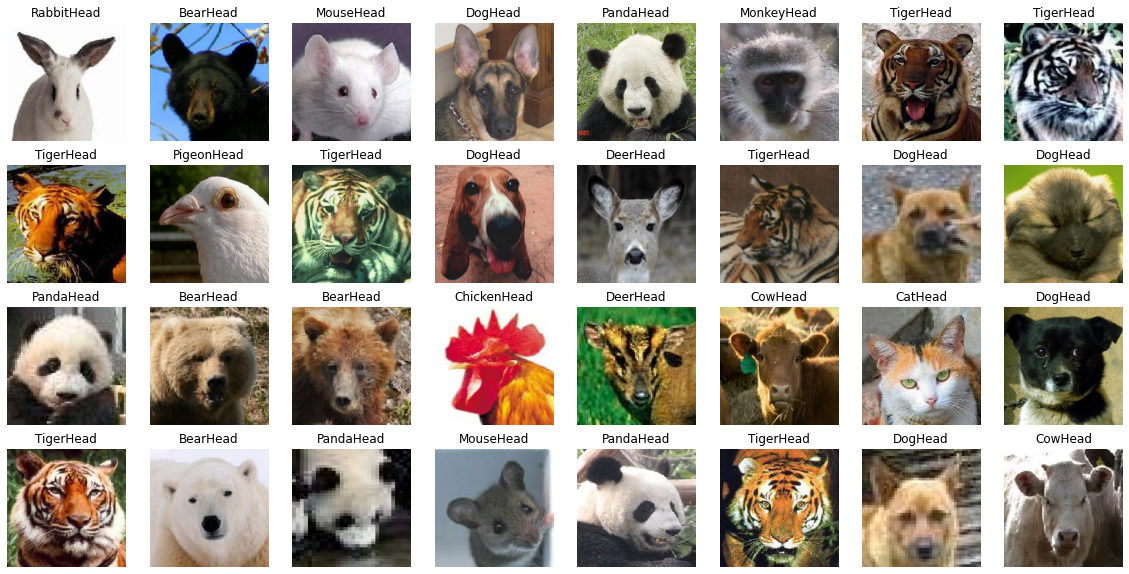

In [13]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()

images, labels = train_set[0]
for i in range(len(images)):
    label_index = np.argmax(labels[i])
    image, label = images[i], int_to_class[label_index]
    axes[i].imshow(image.astype("uint8"))
    axes[i].set_title(label)
    axes[i].axis('off')